In [1]:
#! pip install nibabel -U

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

import surface_distance_based_measures

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
task_number = "04"
task_name = "hippocampus".lower()
path = "./Task%s_%s/3d_fullres" % (task_number, task_name.capitalize())
file_prefix = task_name

run_data = [
    "A40/22933937",
    "A100/22933910",
    "A100/22969078",
    "A100/22972197",
    "A100/22972221",
    "A100/22996510",
]

validation_raw_numbers = [
    "017",
    "019",
    "033",
    "035",
    "037",
    "049",
    "052",
    "065",
    "083",
    "088",
    "090",
    "092",
    "095",
    "107",
    "108",
    "123",
    "125",
    "157",
    "164",
    "169",
    "175",
    "185",
    "190",
    "194",
    "204",
    "205",
    "210",
    "217",
    "219",
    "229",
    "244",
    "261",
    "264",
    "277",
    "280",
    "286",
    "288",
    "289",
    "296",
    "305",
    "308",
    "317",
    "327",
    "330",
    "332",
    "338",
    "349",
    "350",
    "356",
    "358",
    "374",
    "394",
]

results = []

In [5]:
# Calculate DSC: Dice Similarity Coefficient; NSD: Normalized Surface Distance
for run in run_data:

    run_info = {}
    run_info[run] = {}

    for validation_raw_number in validation_raw_numbers:

        run_info[run][validation_raw_number] = {}

        # Ground Truth
        mask_gt_img = nib.load(
            "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
            % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
        )
        mask_gt = np.array(mask_gt_img.dataobj)

        # Run data
        mask_pred_img = nib.load(
            "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
            % (path, run, file_prefix, validation_raw_number)
        )
        mask_pred = np.array(mask_pred_img.dataobj)

        # Calculate Dice Score
        run_info[run][validation_raw_number][
            "dice_similarity_coefficient"
        ] = surface_distance_based_measures.compute_dice_coefficient(mask_gt, mask_pred)

        # Calculate Normalized Surface Distance
        spacing_mm = (3, 2, 1)
        surface_distances = surface_distance_based_measures.compute_surface_distances(
            mask_gt, mask_pred, spacing_mm
        )
        run_info[run][validation_raw_number][
            "normalized_surface_distance"
        ] = surface_distance_based_measures.compute_surface_dice_at_tolerance(
            surface_distances, 1
        )

    results.append(run_info)

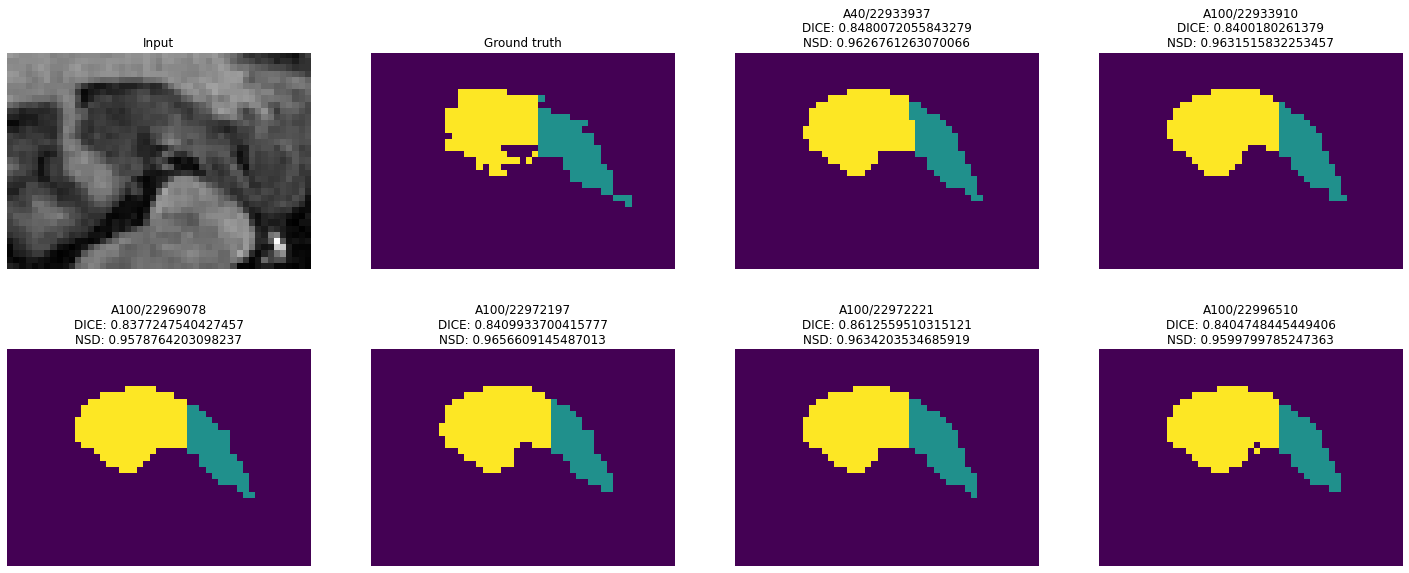

In [6]:
validation_raw_number = "350"
display_layer = 15

# Calculate the number of rows based on the size of results + 2 (input & ground truth)
# and the value of n_cols
n_cols = 4
n_rows = int(np.ceil((len(results) + 2) / n_cols))

# Define the number of rows and columns and set the graph size
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, n_rows * 5))

# Hide the graph axes
for ax in axes.flatten():
    ax.axis("off")

# Display the input image as the first image
axes[0, 0].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/imagesTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer],
    cmap="gray",
)
axes[0, 0].set_title("Input")

# Display the ground truth as the second image
axes[0, 1].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer]
)
axes[0, 1].set_title("Ground truth")


for i, result in enumerate(results):

    # The first key should the run name (ie A100/12345678)
    run = list(result.keys())[0]

    image_path = (
        "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
        % (path, run, file_prefix, validation_raw_number)
    )

    # Use i + 2 instead of i because of the input image and the ground truth always being the first 2 images

    # Calculate the row number by dividing the list item number by the number of columns and rounding down
    row = int(np.floor((i + 2) / n_cols))
    # Calculate the column number by finding the remainder of the list item number divided by the number of columns
    column = int(np.remainder((i + 2), n_cols))

    # Display the display_layer layer of the image
    axes[row, column].imshow(nib.load(image_path).get_fdata()[:, :, display_layer])
    axes[row, column].set_title(
        "%s\nDICE: %s\nNSD: %s"
        % (
            run,
            result[run][validation_raw_number]["dice_similarity_coefficient"],
            result[run][validation_raw_number]["normalized_surface_distance"],
        )
    )

### Create a dataframe with just the dice scores

In [7]:
dice_scores = pd.DataFrame(index=validation_raw_numbers, columns=run_data)

for result in results:

    run = list(result.keys())[0]

    for validation_raw_number in list(result[run].keys()):
        dice_scores[run][validation_raw_number] = result[run][validation_raw_number][
            "dice_similarity_coefficient"
        ]

dice_scores.head()

,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,A100/22996510
017,0.920198,0.918092,0.920547,0.92623,0.921633,0.918145
019,0.867759,0.860952,0.865145,0.865141,0.861853,0.864329
033,0.879154,0.87941,0.880789,0.881959,0.879507,0.885729
035,0.891134,0.890442,0.898022,0.891429,0.896927,0.891967
037,0.840171,0.836107,0.839263,0.840017,0.8365,0.841995


### Create a new column with the dice score range

In [8]:
dice_scores["range"] = dice_scores.max(axis=1) - dice_scores.min(axis=1)

### Sort the dataframe by the dice score "range" column

In [9]:
dice_scores.sort_values(by=["range"], ascending=False).head()

,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,A100/22996510,range
350,0.848007,0.840018,0.837725,0.840993,0.861256,0.840475,0.023531
049,0.909223,0.904299,0.927421,0.916833,0.918345,0.915488,0.023122
330,0.763864,0.758805,0.750313,0.756238,0.768208,0.76894,0.018628
217,0.857281,0.863107,0.864633,0.874985,0.86848,0.867023,0.017704
244,0.85939,0.857231,0.855347,0.85726,0.85776,0.843284,0.016105
